In [1]:
# imports & config
from __future__ import annotations
from pathlib import Path
import json, functools, math
import numpy as np
import pandas as pd
import soundfile as sf
import librosa, librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from scipy import signal
import ipywidgets as widgets

# Consistente stijl
plt.rcParams["figure.dpi"] = 120

# Dataset-root
DATA_ROOT = Path("../data").resolve()

# Verwacht: twee taken en twee microfoonlabels
TASKS = ["coughing", "heartsounds"]
MICS  = ["new_microphone", "old_microphone"]

# Segment & audio-constanten uit jouw beschrijving
SEG_DUR = 3.0      # seconden
SR_FIXED = 15750   # Hz (altijd 15750 volgens .json)

# STFT / Mel default
N_FFT = 1024
HOP   = 256
WIN   = "hann"
N_MELS = 128

In [2]:
# Block A: scan .wav + .json files and build dataframes

def find_wavs_and_jsons(root: Path) -> pd.DataFrame:
    """
    Return a DataFrame with one row per .wav file.
    Columns: path, relpath, task, mic, json_path
    """
    rows = []
    for task in TASKS:
        for mic in MICS:
            base = root / task / mic
            if not base.is_dir():
                continue
            # Search all .wav files (recursively) in this folder
            for wav in sorted(base.rglob("*.wav")):
                # Each .wav file may have a sidecar .json with segment info
                js = wav.with_suffix(".json")
                rows.append({
                    "path": str(wav.resolve()),                   # Full absolute path
                    "relpath": str(wav.relative_to(root).as_posix()),  # Path relative to root folder
                    "task": task,                                 # Task name (e.g., breathing, speech)
                    "mic": mic,                                   # Microphone ID or type
                    "json_path": str(js.resolve()) if js.exists() else None,  # JSON file if available
                })
    # Build DataFrame and sort by task, mic, and file path
    df = pd.DataFrame(rows).sort_values(["task", "mic", "relpath"]).reset_index(drop=True)
    return df


def read_segments_from_json(json_path: Path) -> list[dict]:
    """
    Read segments from a sidecar .json file (same structure as the example).
    Returns a list of dictionaries with:
    id, t_start, t_end, duration, and labels (list of strings)
    """
    with open(json_path, "r", encoding="utf-8") as f:
        d = json.load(f)
    segs = d.get("segments", [])

    out = []
    for s in segs:
        t0 = float(s["t_start"])
        t1 = float(s["t_end"])
        out.append({
            "seg_id": s["id"],            # Segment unique ID
            "t_start": t0,                # Segment start time in seconds
            "t_end": t1,                  # Segment end time in seconds
            "dur": t1 - t0,               # Duration (seconds)
            "labels": list(s.get("labels", [])),  # Labels (if present)
        })
    return out


def build_segments_table(df_files: pd.DataFrame) -> pd.DataFrame:
    """
    Build a DataFrame with one row per segment.
    Columns: path, relpath, task, mic, seg_id, t_start, t_end, dur, labels
    """
    rows = []

    # Go through each file and load its segments if a JSON file exists
    for _, r in df_files.iterrows():
        if r["json_path"] is None:
            continue
        segs = read_segments_from_json(Path(r["json_path"]))
        for s in segs:
            rows.append({
                "path": r["path"],
                "relpath": r["relpath"],
                "task": r["task"],
                "mic": r["mic"],
                "seg_id": s["seg_id"],
                "t_start": s["t_start"],
                "t_end": s["t_end"],
                "dur": s["dur"],
                "labels": s["labels"],
            })

    # Convert list of rows into a DataFrame
    df = pd.DataFrame(rows)

    # Sort for easier reading and consistency
    if not df.empty:
        df = df.sort_values(["task", "mic", "relpath", "t_start"]).reset_index(drop=True)

    return df

In [3]:
# Run Block A
df_files = find_wavs_and_jsons(DATA_ROOT)
print(f"Aantal .wav-bestanden: {len(df_files)}")
display(df_files.head(3))

Aantal .wav-bestanden: 40


,path,relpath,task,mic,json_path
0,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...
1,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_2.wav,coughing,new_microphone,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...
2,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_3.wav,coughing,new_microphone,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...


In [4]:
# Run Block A
df_segs  = build_segments_table(df_files)
print(f"Aantal segmenten: {len(df_segs)}")
display(df_segs.head(5))

Aantal segmenten: 369


,path,relpath,task,mic,seg_id,t_start,t_end,dur,labels
0,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,90084a4e-8a76-43e2-a4dc-da7b6f91737f,1.74,4.74,3.0,[Hoest]
1,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,8b5383c1-b95b-49b6-89b4-4a0534268fad,6.91,9.91,3.0,[Hoest]
2,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,9d213259-75ac-428e-83e2-10dbe74a88e3,11.93,14.93,3.0,[Hoest]
3,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,c2b67ec8-0263-4b8a-be39-088835a9678f,16.77,19.77,3.0,[Hoest]
4,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,e712c1eb-c012-4b39-bf22-b9c94126352d,21.38,24.38,3.0,[Hoest]


In [5]:
# Block B: helper functions for audio, filtering, and spectrograms

# AUDIO LOADING

@functools.lru_cache(maxsize=1024)
def load_audio_cached(wav_path: str) -> tuple[np.ndarray, int]:
    """
    Load a mono audio signal and its sample rate directly from disk.
    Keeps the original sample rate (expected: 15750 Hz).

    Uses an LRU cache so repeated calls to the same file are fast.
    Returns
    -------
    y : np.ndarray
        The audio samples as a NumPy array (float32).
    sr : int
        The sampling rate of the file.
    """
    y, sr = sf.read(wav_path, dtype="float32", always_2d=False)
    if y.ndim == 2:
        # If stereo, convert to mono by averaging both channels
        y = y.mean(axis=1)
    return y.astype(np.float32), int(sr)

# SIGNAL SLICING

def slice_seconds(y: np.ndarray, sr: int, t0: float, t1: float) -> np.ndarray:
    """
    Extract a part of the signal between t0 and t1 (in seconds).

    Parameters
    ----------
    y : np.ndarray
        The full audio signal.
    sr : int
        Sampling rate in Hz.
    t0, t1 : float
        Start and end times (in seconds).

    Returns
    -------
    np.ndarray
        The sliced audio segment (clamped to signal boundaries).
    """
    a = max(0, int(round(t0 * sr)))        # Convert start time to sample index
    b = min(len(y), int(round(t1 * sr)))   # Convert end time to sample index
    return y[a:b]

# BANDPASS FILTER

def bandpass_filter(y: np.ndarray, fs: int, fc=(50.0, 2000.0), order=4, zero_phase=True) -> np.ndarray:
    """
    Apply a Butterworth band-pass filter.

    If zero_phase=True, use filtfilt (forward + backward filtering)
    to remove any phase shift (zero time delay).

    Parameters
    ----------
    y : np.ndarray
        Input signal.
    fs : int
        Sampling frequency (Hz).
    fc : tuple(float, float)
        (low_cut, high_cut) frequencies in Hz.
    order : int
        Filter order (steeper roll-off for higher order).
    zero_phase : bool
        If True → no phase distortion using filtfilt.

    Returns
    -------
    np.ndarray
        Filtered signal (float32).
    """
    low, high = fc
    # Ensure the high cutoff is below Nyquist frequency
    high = min(high, fs / 2 - 1.0)

    # Design Butterworth band-pass filter
    sos = signal.butter(order, [low, high], btype="bandpass", fs=fs, output="sos")

    # Apply the filter
    if zero_phase:
        # Zero-phase: filter forward and backward
        return signal.sosfiltfilt(sos, y).astype(np.float32)
    else:
        # Single-pass filter (can introduce small delay)
        return signal.sosfilt(sos, y).astype(np.float32)

# SPECTROGRAMS (STFT and MEL)

def stft_db(y: np.ndarray, sr: int, n_fft=N_FFT, hop_length=HOP, win=WIN) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute a Short-Time Fourier Transform (STFT) in decibels.

    Returns both the dB-scaled spectrogram and the time/frequency axes.
    """
    # Compute the STFT matrix
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft,
                     window=win, center=True)

    # Convert amplitude to decibels (log scale)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Compute time and frequency axes
    times = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr,
                                   hop_length=hop_length, n_fft=n_fft)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    return S_db, times, freqs


def mel_db(y: np.ndarray, sr: int, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute a Mel-spectrogram in decibels.

    The Mel scale approximates how humans perceive sound frequency.
    Returns both the dB-scaled spectrogram and the time/frequency axes.
    """
    # Compute Mel power spectrogram
    M = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                       hop_length=hop_length,
                                       n_mels=n_mels, power=2.0)

    # Convert power to decibels
    M_db = librosa.power_to_db(M, ref=np.max)

    # Compute time and (Mel) frequency axes
    times = librosa.frames_to_time(np.arange(M_db.shape[1]), sr=sr,
                                   hop_length=hop_length, n_fft=n_fft)
    freqs = librosa.mel_frequencies(n_mels=M_db.shape[0],
                                    fmin=0.0, fmax=sr / 2.0)

    return M_db, times, freqs

C:\Users\Esmee Werk\AppData\Local\Temp\ipykernel_29600\632533520.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


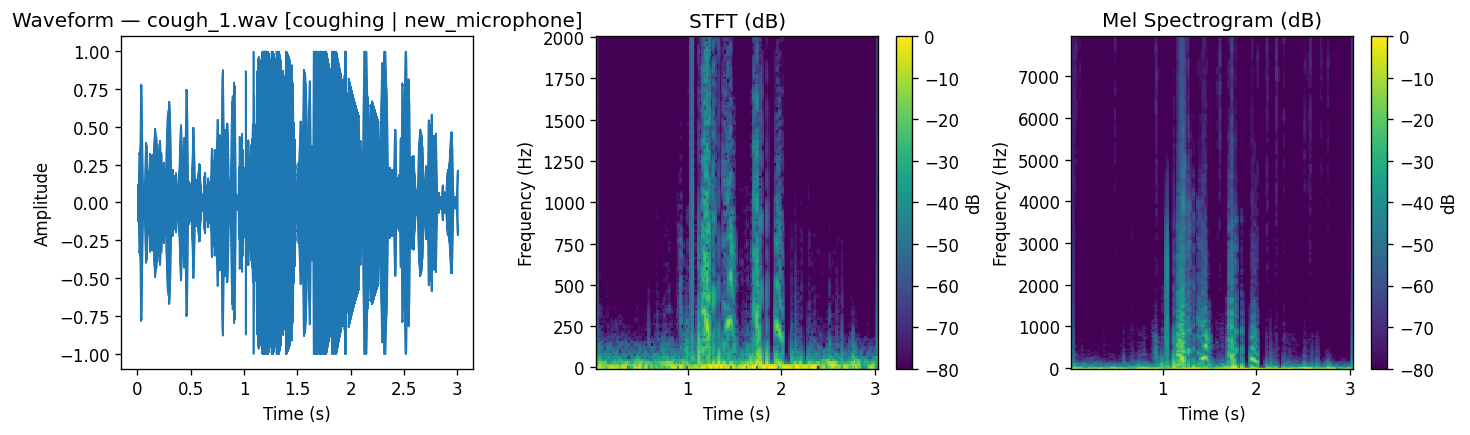

In [6]:
# Block C: simple plotting helpers

def plot_triplet(y: np.ndarray, sr: int, title_prefix: str, fmax=None):
    """
    Plot three visualizations side by side:
    (1) waveform, (2) STFT (in dB), and (3) Mel spectrogram (in dB).

    Parameters
    ----------
    y : np.ndarray
        The audio signal (1D array).
    sr : int
        Sampling rate in Hz.
    title_prefix : str
        Text added to the figure title (e.g., file name or task).
    fmax : float, optional
        Upper frequency limit for the STFT display (in Hz).
        If not given, defaults to half of the sampling rate.
    """
    # Create figure with 3 subplots in one row
    fig = plt.figure(figsize=(14, 3.6))
    gs = fig.add_gridspec(1, 3, wspace=0.35)

    # (1) Waveform
    ax0 = fig.add_subplot(gs[0, 0])
    librosa.display.waveshow(y, sr=sr, ax=ax0)
    ax0.set_title(f"Waveform — {title_prefix}")
    ax0.set_xlabel("Time (s)")
    ax0.set_ylabel("Amplitude")

    # (2) STFT (Short-Time Fourier Transform)
    ax1 = fig.add_subplot(gs[0, 1])
    S_db, tS, fS = stft_db(y, sr)
    if fmax is None:
        fmax = sr / 2.0  # Default to Nyquist frequency
    mask = fS <= fmax   # Limit display to desired frequency range
    im1 = ax1.pcolormesh(tS, fS[mask], S_db[mask, :], shading="auto")
    ax1.set_title("STFT (dB)")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Frequency (Hz)")
    cb1 = fig.colorbar(im1, ax=ax1)
    cb1.set_label("dB")

    # (3) Mel Spectrogram
    ax2 = fig.add_subplot(gs[0, 2])
    M_db, tM, fM = mel_db(y, sr)
    im2 = ax2.pcolormesh(tM, fM, M_db, shading="auto")
    ax2.set_title("Mel Spectrogram (dB)")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Frequency (Hz)")
    cb2 = fig.colorbar(im2, ax=ax2)
    cb2.set_label("dB")

    plt.tight_layout()
    plt.show()


# Example: first segment from the first file (if available)
if len(df_segs):
    # Select the first row from the segments table
    r0 = df_segs.iloc[0]

    # Load the corresponding audio file
    y, sr = load_audio_cached(r0["path"])

    # Extract only the labeled segment (start to end time)
    y_seg = slice_seconds(y, sr, r0["t_start"], r0["t_end"])

    # Build a readable title with file name, task, and microphone
    title = f"{Path(r0['path']).name} [{r0['task']} | {r0['mic']}]"

    # Plot waveform, STFT, and Mel spectrogram for this segment
    plot_triplet(y_seg, sr, title_prefix=title, fmax=2000.0)

    # Play back the selected audio segment
    display(Audio(y_seg, rate=sr))
else:
    print("No segments found.")

In [7]:
# Block D: interactive viewer + playback with optional band-pass filter

# This block creates an interactive UI to:
# - browse through files
# - optionally apply a band-pass filter (with adjustable low/high/order/zero-phase)
# - visualize waveform and STFT
# - play back the (optionally filtered) audio

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import ipywidgets as widgets
from IPython.display import Audio, display

# Widget configuration (these inherit defaults defined elsewhere)
n_fft = N_FFT
hop_length = HOP
win = WIN

# UI controls (left column)

idx_slider   = widgets.IntSlider(
    value=0, min=0, max=max(0, len(df_files) - 1), step=1, description='Index:'
)
use_filter   = widgets.Checkbox(value=False, description='Enable band-pass')
low_box      = widgets.FloatText(value=50.0, description='Low (Hz):', step=1.0)
high_box     = widgets.FloatText(value=2000.0, description='High (Hz):', step=1.0)
order_slider = widgets.IntSlider(value=4, min=1, max=12, step=1, description='Order:')
zero_chk     = widgets.Checkbox(value=True, description='Zero-phase')

# Assemble left-side control panel and an output area on the right
ui_left  = widgets.VBox([idx_slider, use_filter, low_box, high_box, order_slider, zero_chk])
out_area = widgets.Output()

def _update(idx, use_filter, low, high, order, zero_phase):
    """
    Update function called whenever a widget changes.
    - Loads the selected audio file (cached)
    - Optionally applies band-pass filtering
    - Plots waveform and STFT
    - Renders an audio player for listening
    """
    with out_area:
        # Clear plot/output area so we re-draw fresh content
        out_area.clear_output(wait=True)

        # 1) Pick the file based on index
        row = df_files.iloc[int(idx)]
        wav_file = row["path"]
        task_lbl = row.get("task", "unknown")
        mic_lbl  = row.get("mic",  "unknown")
        title_suffix = f"[{task_lbl} | {mic_lbl}]"

        # 2) Load audio from disk (cached)
        y, sr = load_audio_cached(wav_file)

        # 3) Optionally filter (operate on y_view; original y unchanged)
        y_view = y
        if use_filter:
            # Clamp high cutoff to stay below Nyquist; keep it > low cutoff
            high_eff = min(float(high), sr / 2 - 1.0)
            if high_eff <= float(low):
                # If user sets high <= low, nudge it up a bit for stability
                high_eff = min(float(low) + 10.0, sr / 2 - 1.0)

            # Apply band-pass with user-provided parameters
            y_view = bandpass_filter(
                y_view, fs=sr, fc=(float(low), high_eff),
                order=int(order), zero_phase=bool(zero_phase)
            )
            fmax_plot = high_eff  # cap STFT display at the effective high cutoff
        else:
            fmax_plot = sr / 2.0  # display full frequency range up to Nyquist

        # 4) Plot: Waveform
        plt.figure(figsize=(12, 3))
        librosa.display.waveshow(y_view, sr=sr)
        plt.title(f"Waveform — {Path(wav_file).name} {title_suffix}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()

        # 5) Plot: STFT (dB)
        # Compute STFT and convert magnitude to dB
        S = librosa.stft(y_view, n_fft=n_fft, hop_length=hop_length,
                         win_length=n_fft, window=win, center=True)
        S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

        # Time and frequency axes
        times = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr,
                                       hop_length=hop_length, n_fft=n_fft)
        freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

        # Limit the plotted frequencies to fmax_plot
        mask = freqs <= fmax_plot
        if not np.any(mask):  # safety: if mask is empty, fall back to Nyquist
            mask = freqs <= (sr / 2.0)
        freqs_plot = freqs[mask]
        S_db_plot  = S_db[mask, :]

        plt.figure(figsize=(12, 4))
        plt.pcolormesh(times, freqs_plot, S_db_plot, shading="auto")
        plt.title(f"STFT — {Path(wav_file).name} {title_suffix}")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        cbar = plt.colorbar()
        cbar.set_label("Amplitude (dB)")
        plt.ylim(0.0, fmax_plot)
        plt.tight_layout()
        plt.show()

        # 6) Audio player
        # Play the full (possibly filtered) clip
        display(Audio(y_view, rate=sr))

# Map widget objects to the _update function’s parameter names
controls = {
    'idx': idx_slider,
    'use_filter': use_filter,
    'low': low_box,
    'high': high_box,
    'order': order_slider,
    'zero_phase': zero_chk,
}

# Connect widgets to output via interactive_output (keeps layout flexible)
linked_out = widgets.interactive_output(_update, controls)

# Display side-by-side: controls (left) and output area (right)
display(widgets.HBox([ui_left, out_area]))

# Initial render
if len(df_files):
    _update(idx_slider.value, use_filter.value, low_box.value, high_box.value,
            order_slider.value, zero_chk.value)
else:
    with out_area:
        print("No audio files found in df_files.")

In [8]:
def show_segment(row_seg: pd.Series,
                 apply_filter: bool = False,
                 low: float = 50.0,
                 high: float = 2000.0,
                 order: int = 4,
                 zero_phase: bool = True) -> None:
    """
    Visualize and play a single labeled segment.

    Steps:
      1) Load the audio file for this segment (cached)
      2) Slice the audio between t_start and t_end
      3) Optionally apply a band-pass filter
      4) Plot waveform, STFT(dB), and Mel(dB)
      5) Play the audio of the selected segment

    Parameters
    ----------
    row_seg : pd.Series
        A row from df_segs with fields: path, t_start, t_end, labels, mic.
    apply_filter : bool
        If True, apply band-pass with the parameters below.
    low, high : float
        Band-pass cutoffs in Hz.
    order : int
        Butterworth filter order.
    zero_phase : bool
        If True, use zero-phase filtering (filtfilt).
    """
    # Load full audio (cached) and slice to the segment’s time span
    y, sr = load_audio_cached(row_seg["path"])
    y_seg = slice_seconds(y, sr, row_seg["t_start"], row_seg["t_end"])

    # Optional band-pass filter (keep effective high below Nyquist)
    if apply_filter:
        high_eff = min(float(high), sr / 2 - 1.0)
        y_seg = bandpass_filter(
            y_seg, fs=sr, fc=(float(low), high_eff),
            order=int(order), zero_phase=bool(zero_phase)
        )
    else:
        high_eff = 2000.0  # cap for plotting when no filter is applied

    # Build a readable title with labels and mic info
    label_text = ", ".join(row_seg.get("labels", []))
    title = f"{Path(row_seg['path']).name} | label: {label_text} | {row_seg.get('mic', 'unknown')}"

    # Plot the three-panel view; limit STFT freq range to the effective high cutoff
    fmax_for_plot = min(high_eff, sr / 2.0) if apply_filter else high_eff
    plot_triplet(y_seg, sr, title_prefix=title, fmax=fmax_for_plot)

    # Audio player for the extracted segment
    display(Audio(y_seg, rate=sr))

C:\Users\Esmee Werk\AppData\Local\Temp\ipykernel_29600\632533520.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


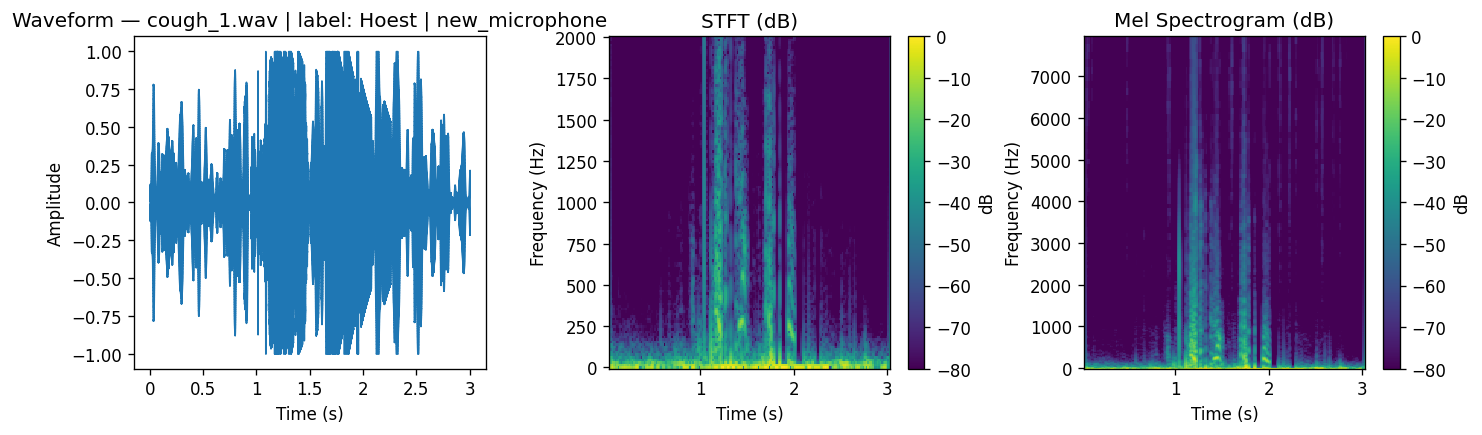

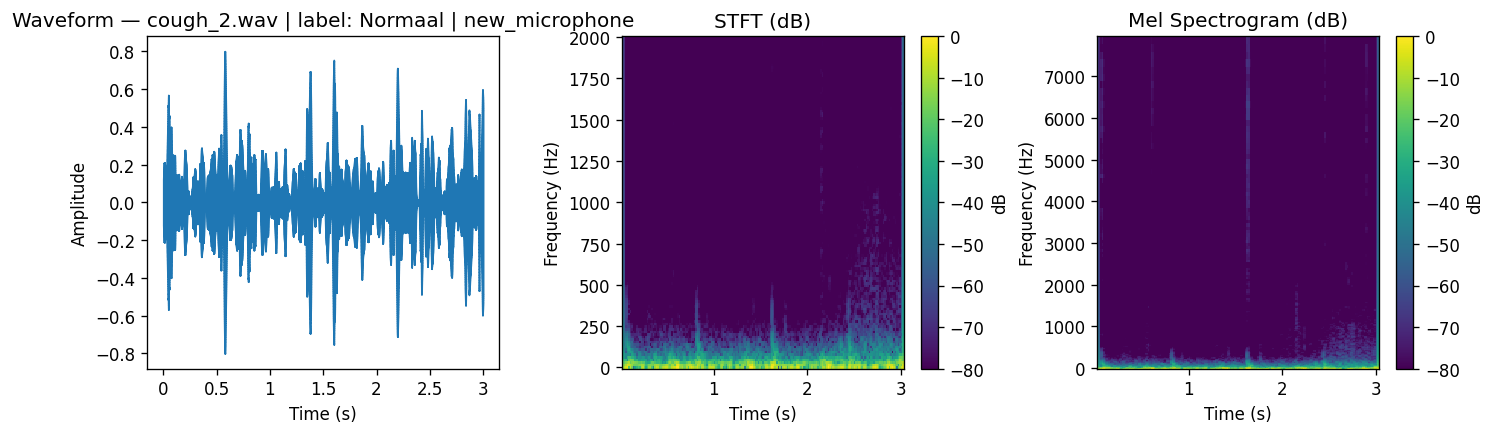

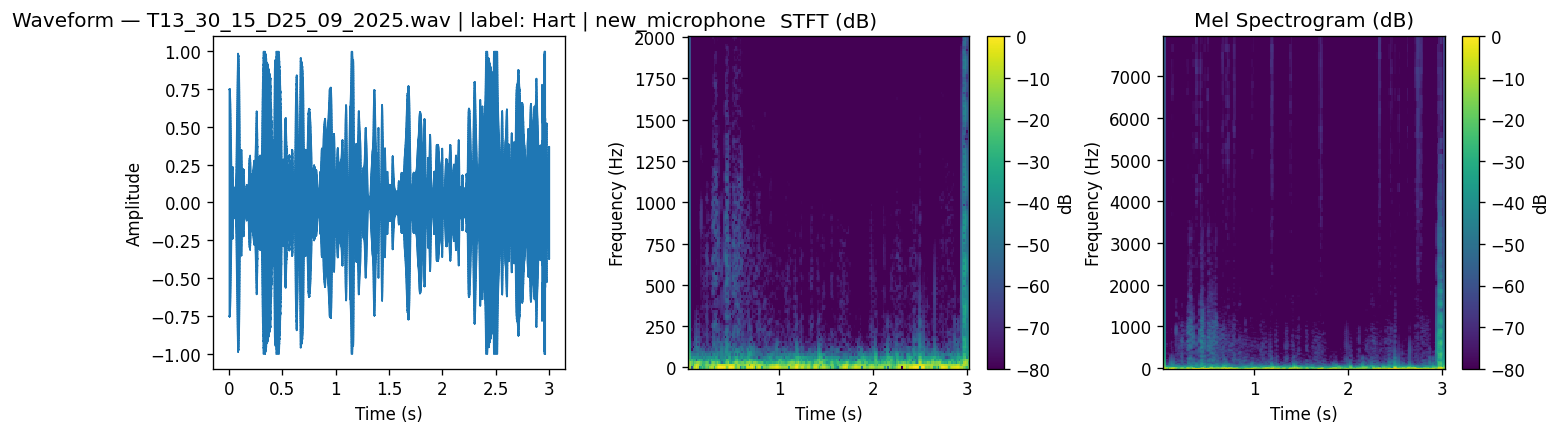

In [9]:
# Example: plot one segment for each label category
# (adjust label names to your dataset)

# Dutch labels (current dataset)
try:
    row_cough  = df_segs[df_segs["labels"].apply(lambda labels: "Hoest" in labels)].iloc[0]
    show_segment(row_cough, apply_filter=False)
except IndexError:
    print("No 'Hoest' (cough) segments found.")

try:
    row_normal = df_segs[df_segs["labels"].apply(lambda labels: "Normaal" in labels)].iloc[0]
    show_segment(row_normal, apply_filter=False)
except IndexError:
    print("No 'Normaal' (normal) segments found.")

try:
    row_heart  = df_segs[df_segs["labels"].apply(lambda labels: "Hart" in labels)].iloc[0]
    show_segment(row_heart, apply_filter=False)
except IndexError:
    print("No 'Hart' (heart) segments found.")